In [48]:
import numpy as np
import gc
import copy
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
import os
import pickle
import matplotlib
import seaborn as sns

from feat_loading import *

In [4]:
app_train = load_dataframe("train_all.csv")
app_test = load_dataframe("test_all.csv")
app_train, app_test = load_extra_feats_post(app_train, app_test)
to_del = del_single_variance_and_nan_too_much(app_train)
app_test = app_test.drop(to_del, axis=1)


BURO_CREDIT_SUM_LIMIT_DEBT_RATIO_VAR
ACTIVE_CREDIT_SUM_LIMIT_DEBT_RATIO_VAR
ACTIVE_MAX_OVERDUE_RATIO_VAR
CLOSED_CREDIT_SUM_LIMIT_DEBT_RATIO_MIN
CLOSED_CREDIT_SUM_LIMIT_DEBT_RATIO_MAX
CLOSED_CREDIT_SUM_LIMIT_DEBT_RATIO_MEAN
CLOSED_CREDIT_SUM_LIMIT_DEBT_RATIO_VAR
CLOSED_CREDIT_SUM_LIMIT_OVERDUE_RATIO_MIN
CLOSED_CREDIT_SUM_LIMIT_OVERDUE_RATIO_MAX
CLOSED_CREDIT_SUM_LIMIT_OVERDUE_RATIO_MEAN
CLOSED_CREDIT_SUM_LIMIT_OVERDUE_RATIO_VAR
PREV_INTREST_RATE_RATIO_MAX
PREV_INTREST_RATE_RATIO_MEAN
PREV_INTREST_RATE_RATIO_VAR
APPROVED_INTREST_RATE_RATIO_MAX
APPROVED_INTREST_RATE_RATIO_MEAN
APPROVED_INTREST_RATE_RATIO_VAR
REFUSED_APP_DURATION_MAX
REFUSED_APP_DURATION_MEAN
REFUSED_APP_PAY_DURATION_MAX
REFUSED_APP_PAY_DURATION_MEAN
REFUSED_INTREST_RATE_RATIO_MAX
REFUSED_INTREST_RATE_RATIO_MEAN
REFUSED_INTREST_RATE_RATIO_VAR
24 columns need to be dropped


In [ ]:
for alg in ["RF", "ET", "CB", "MLP"]:
    oof = load_dataframe(alg + "_oof.csv")
    app_train = app_train.merge(right=oof.reset_index(), how='left', on='SK_ID_CURR')
    del oof
    gc.collect()
    
    t_oof = load_dataframe(alg + "_test.csv")
    app_test = app_test.merge(right=t_oof.reset_index(), how='left', on='SK_ID_CURR')
    del t_oof
    gc.collect()

In [45]:
with open("oof/jjsmd.bin", "rb") as f:
    fi_past = pickle.load(f)
    
bad_features = fi_past.sort_values("importance", ascending=False)["feature"][300:].tolist()
app_train = app_train.drop(columns=bad_features)
app_test = app_test.drop(columns=bad_features)

In [46]:
bad_features

['PREV_PRODUCT_COMBINATION_Cash Street: low_MEAN',
 'PREV_NAME_PRODUCT_TYPE_walk-in_MEAN',
 'PREV_PRODUCT_COMBINATION_Cash_MEAN',
 'PREV_NAME_PAYMENT_TYPE_Cash through the bank_MEAN',
 'APPROVED_AMT_GOODS_PRICE_MEAN',
 'REFUSED_APP_CREDIT_PERC_MEAN',
 'BURO_AMT_ANNUITY_MAX',
 'CC_AMT_DRAWINGS_ATM_CURRENT_MEAN',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN',
 'POS_SK_DPD_MEAN',
 'CC_RECEIVABLE_PRINCIPAL_DIFF_MAX',
 'REFUSED_AMT_ANNUITY_MEAN',
 'PREV_NAME_GOODS_CATEGORY_Mobile_MEAN',
 'PREV_PRODUCT_COMBINATION_POS industry with interest_MEAN',
 'PREV_NAME_PORTFOLIO_XNA_MEAN',
 'CLOSED_AMT_ANNUITY_MEAN',
 'CC_POS_AMT_MEAN_VAR',
 'FLOORSMIN_MEDI',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'document_sum',
 'PREV_NAME_CONTRACT_STATUS_Canceled_MEAN',
 'POS_SK_DPD_MAX',
 'ACTIVE_AMT_ANNUITY_MAX',
 'ORGANIZATION_TYPE_Self-employed',
 'APPROVED_HOUR_APPR_PROCESS_START_MIN',
 'CC_AMT_PAYMENT_CURRENT_MAX',
 'BURO_CREDIT_SUM_LIMIT_DEBT_RATIO_MIN',
 'REFUSED_CREDIT_TO_GOODS_RATIO_

In [ ]:
import modelling
importlib.reload(modelling)

gc.collect()

cat_feats = ['NAME_CONTRACT_TYPE', 
              'FLAG_OWN_CAR', 
             'FLAG_OWN_REALTY']
submission, fi, metrics = modelling.model(app_train, app_test, cat_feats, parallel=5)
print('Baseline metrics')
print(metrics)
submission.to_csv('stacked.csv', index = False)

c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_CONTRACT_TYPE']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 300 rounds.
[200]	train's binary_logloss: 0.228581	train's auc: 0.81328	valid's binary_logloss: 0.235493	valid's auc: 0.787138
[400]	train's binary_logloss: 0.220008	train's auc: 0.835471	valid's binary_logloss: 0.23508	valid's auc: 0.788239
[600]	train's binary_logloss: 0.212209	train's auc: 0.854873	valid's binary_logloss: 0.234945	valid's auc: 0.788675
[800]	train's binary_logloss: 0.205135	train's auc: 0.87177	valid's binary_logloss: 0.234914	valid's auc: 0.788666
Early stopping, best iteration is:
[645]	train's binary_logloss: 0.210562	train's auc: 0.858917	valid's binary_logloss: 0.234879	valid's auc: 0.788838
Training until validation scores don't improve for 300 rounds.
[200]	train's binary_logloss: 0.228168	train's auc: 0.813255	valid's binary_logloss: 0.23693	valid's auc: 0.786727
[400]	train's binary_logloss: 0.219384	train's auc: 0.836299	valid's binary_logloss: 0.236379	valid's auc: 0.788138
[600]	train's binary_logloss: 0

In [ ]:
importlib.reload(modelling)
fi_sorted = modelling.plot_feature_importances(fi, 100)
# display(fi_sorted[fi_sorted["feature"]=="ORG_XNA_no_Pensioner"])
print(fi_sorted[fi_sorted["importance"]==0]["feature"].tolist())

In [24]:
oof_path = "oof"

test = load_dataframe(os.path.join(oof_path, "improved_lgb_all_tables21.csv"))
test.columns = ['SK_ID_CURR', "LGB"]

oof = load_dataframe(os.path.join(oof_path, "LGB_oof.csv"))


In [ ]:
app_test = load_dataframe("test_all.csv")
app_train = load_dataframe("train_all.csv")

In [25]:
for file in os.listdir(oof_path):
    if not file.endswith(".csv"):
        continue
    df = load_dataframe(os.path.join(oof_path, file))
    if file.endswith("oof.csv") and "LGB" not in file:
        oof = oof.merge(right=df.reset_index(), how='left', on='SK_ID_CURR')
        oof = oof.drop("index", axis=1)
    elif file.endswith("test.csv"):
        test = test.merge(right=df.reset_index(), how='left', on='SK_ID_CURR')
        test = test.drop("index", axis=1)

In [36]:
X = oof.drop(['SK_ID_CURR', "ET"], axis=1)
y = app_train["TARGET"]
tX = test.drop(['SK_ID_CURR', "ET",
                "TARGET"
               ], axis=1)
lr = LogisticRegressionCV()
lr.fit(X, y)
test['TARGET'] = lr.predict_proba(tX)[:,1]
test[['SK_ID_CURR', 'TARGET']].to_csv('stacking_submission4.csv', index=False, float_format='%.8f')

In [34]:
X = oof.drop(['SK_ID_CURR'], axis=1)
y = app_train["TARGET"]
tX = test.drop(['SK_ID_CURR', 
                "TARGET"
               ], axis=1)
tc = DecisionTreeClassifier()
tc.fit(X, y)
test['TARGET'] = tc.predict_proba(tX)[:,1]
test[['SK_ID_CURR', 'TARGET']].to_csv('stacking_submission3.csv', index=False, float_format='%.8f')

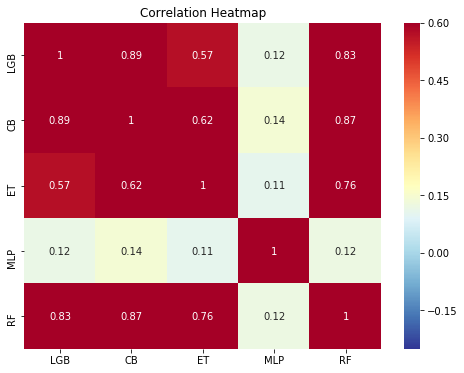

In [49]:
data_corrs = oof.drop(['SK_ID_CURR'], axis=1).corr()
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');